<a href="https://colab.research.google.com/github/cnovak232/DL_Speech_Enhancement/blob/segan/segan_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Data by cloning the repo - easiest way to access shared data

In [5]:
!git clone https://github.com/cnovak232/DL_Speech_Enhancement.git

Cloning into 'DL_Speech_Enhancement'...
remote: Enumerating objects: 16494, done.
remote: Counting objects: 100% (5814/5814), done.
remote: Compressing objects: 100% (5788/5788), done.
remote: Total 16494 (delta 27), reused 5811 (delta 25), pack-reused 10680
Receiving objects: 100% (16494/16494), 3.44 GiB | 25.48 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (16398/16398), done.


In [6]:
!git clone https://github.com/santi-pdp/segan.git

Cloning into 'segan'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 305 (delta 1), reused 0 (delta 0), pack-reused 299
Receiving objects: 100% (305/305), 790.04 KiB | 15.80 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [7]:
!pip install PyWavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Define some helper function for plotting and playing audio

In [8]:
import torch
import torchaudio as ta
import librosa as lib
from IPython.display import Audio, display
import matplotlib
import matplotlib.pyplot as plt
import pywt

# helper functions for audio and what not
# mostly taken for torchaudio tutorials 

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block=False)

def get_spectrogram(
    waveform = None,
    n_fft = 512,
    win_len = None,
    hop_len = None,
    power = 1.0 ):
    spectrogram = ta.transforms.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power )
    
    return spectrogram(waveform)

def plot_spectrogram(spec, type = "amplitude", title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    toDb = ta.transforms.AmplitudeToDB(type)
    im = axs.imshow(toDb(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


class DWT(object):
    def __init__(self, name, level):
        self.name = name
        self.level = level

    def __call__(self, x):
        coeffs = pywt.wavedec(x, self.name, level=self.level,mode='per')
        xdwt = torch.empty(0)
        for band in coeffs:
            torch.from_numpy(band)
            xdwt = torch.cat( (xdwt, torch.from_numpy(band)), dim=1)
        return xdwt

class IDWT(object):
    def __init__(self, name, level):
        self.name = name
        self.level = level

    def __call__(self, xdwt):
        length = xdwt.shape[1]
        coeffs = []
        for idx in range(self.level):
            hlen = length // 2
            coeffs.append( xdwt[:,hlen:length].numpy() )
            length = hlen

        coeffs.append( xdwt[:,:length].numpy() )
        coeffs.reverse()

        xr = pywt.waverec(coeffs, self.name, mode='per')
        return torch.from_numpy(xr) 

def norm_spec( spec ):
    return spec, 1
    #normed = spec / spec.max()
    #return normed, spec.max()

Define a Custom Dataset class for the Data and read it in

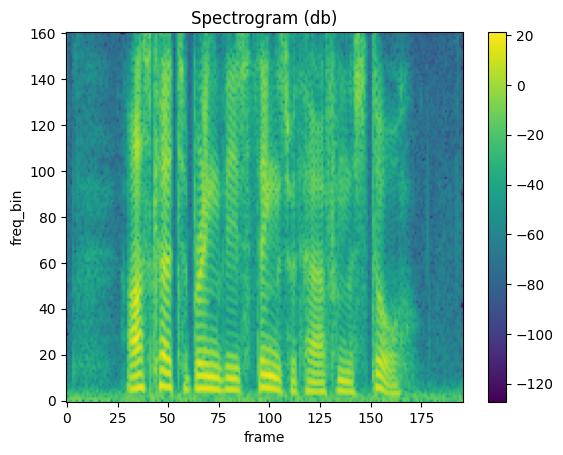

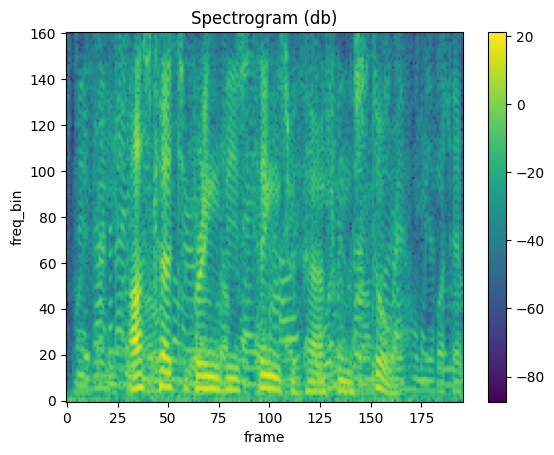

In [35]:
# read dataset in and downsample / transform / pad if needed
from torch.utils.data import Dataset
import torch
import os

class VoiceBankDemand(Dataset):
    def __init__(self, clean_dir, noisy_dir, list_dir, 
                 data = "train", len_samples = None, downsample = None, 
                 transform = None ):
        self.clean_dir = clean_dir
        self.noisy_dir = noisy_dir
        self.list_dir = list_dir
        self.num_samples = len_samples
        self.downsample = downsample
        self.transform = transform
        self.data = data
    
    def __len__(self):
        return len(self.list_dir)

    def __getitem__( self, idx ):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        clean_name = os.path.join( self.clean_dir, self.list_dir[idx] )
        noisy_name = os.path.join( self.noisy_dir, self.list_dir[idx] )
        clean_audio, fs = ta.load(clean_name)
        noisy_audio, fs= ta.load(noisy_name)

        if self.downsample:
            downsampler = ta.transforms.Resample(fs,self.downsample)
            clean_audio = downsampler( clean_audio )
            noisy_audio = downsampler( noisy_audio )

        orig_len = clean_audio.shape[1]

        if self.num_samples:
            # trim or pad audio to fixed length 
            if clean_audio.shape[1] > num_samples:
                clean_audio = clean_audio[:,:num_samples]
                noisy_audio = noisy_audio[:,:num_samples]
            elif clean_audio.shape[1] < num_samples:
                pad_len = int( num_samples - clean_audio.shape[1] )
                pad = torch.zeros(1,pad_len)
                clean_audio = torch.cat((clean_audio,pad), dim=1)
                noisy_audio = torch.cat((noisy_audio,pad),dim=1)
        
        if self.data == "test":
            if self.transform:
                noisy_audio = self.transform( noisy_audio )
                clean_audio = self.transform( clean_audio )
                #clean_mag,_ = torch.abs(clean_trnsfrm) 
                #clean_audio = (clean_audio, clean_mag)
               # noisy_mag, norm_val = torch.abs(noisy_trnsfrm)
                #noisy_phase = torch.angle(noisy_trnsfrm)
                #noisy_audio = (noisy_mag, noisy_phase, noisy_audio, norm_val)
        else:
            if self.transform:
                clean_audio  = self.transform( clean_audio )
                noisy_audio  = self.transform( noisy_audio ) 

        sample = (clean_audio, noisy_audio, orig_len)

        return sample

train_clean_path = './DL_Speech_Enhancement/clean_trainset_28spk_wav'
train_noisy_path = './DL_Speech_Enhancement/noisy_trainset_28spk_wav'
test_clean_path  = './DL_Speech_Enhancement/clean_testset_wav'
test_noisy_path  = './DL_Speech_Enhancement/noisy_testset_wav'

#sort both clean training and testing data
list_dir_train = os.listdir(train_clean_path)
list_dir_train.sort()
list_dir_test = os.listdir(test_clean_path)
list_dir_test.sort()

target_fs = 8000 # downsample to 16 KHz
spectrogram = ta.transforms.Spectrogram(
    n_fft=320, # size for the CRNN
    power=1.0,
    normalized = False )

WAVE_UNET_LEN = 16384 # length the WaveUNET processing
num_samples = WAVE_UNET_LEN * 3


wavelet = DWT( name = 'db8', level = 5 )


# return turns a tuple of ( clean_data,noisy_data,original_length)
# data type depends on if transform was specified
train_set = VoiceBankDemand( clean_dir = train_clean_path,
                             noisy_dir = train_noisy_path,
                             list_dir = list_dir_train,
                             len_samples = None, # clip or pad samples to be 5s
                             downsample = target_fs, # downsample to 16Khz
                             transform = spectrogram )

# returns tuples within tuples: clean_data, noisy_data, original length
# If using a transform (like spectrogram) the subtuples will be:
# clean_data: (clean_waveform, clean_spec)
# noisy_data: ( noisy_spec, noisy_phase, noisy_waveform, normalization_val )
test_set = VoiceBankDemand( clean_dir = test_clean_path,
                            noisy_dir = test_noisy_path,
                            list_dir = list_dir_test,
                            data = "test",
                            len_samples = None,
                            downsample = target_fs,
                            transform = spectrogram )

#############################################################
# for viewing samples and such
clean, noisey, orgin_len = train_set[1]

#transform = DWT( name = 'db4', level = 3 )
#inv_transform = IDWT( name = 'db4', level = 3)
#clean_dwt = transform(clean)


#cleanr = inv_transform(clean_dwt)

#plot_waveform(clean_dwt,target_fs)
#plot_waveform(cleanr,target_fs)

clean_test, noisy_test, orig_len = test_set[0]

#noisy_mag, noisy_phase, noisy_audio, norm_val = noisy_test

plot_spectrogram(clean.squeeze())
plot_spectrogram(noisey.squeeze())

#play_audio(noisy_audio[:,:orig_len],target_fs)

In [10]:
train_set[0]

(tensor([[[1.2946e-01, 8.3714e-01, 5.2215e-01,  ..., 3.1410e-01,
           1.5350e-01, 1.4986e-01],
          [3.8727e-02, 6.6881e-01, 5.8127e-01,  ..., 2.2001e-01,
           2.5494e-01, 5.6804e-02],
          [1.1463e-01, 2.3115e-01, 2.8065e-01,  ..., 7.7669e-02,
           2.8812e-01, 1.1240e-02],
          ...,
          [5.9582e-03, 4.2178e-03, 7.4756e-03,  ..., 1.9350e-03,
           3.8969e-03, 3.1218e-03],
          [1.8482e-03, 5.9964e-04, 5.3254e-03,  ..., 3.6260e-03,
           3.1290e-03, 1.2360e-03],
          [6.0551e-03, 1.2768e-03, 4.7498e-03,  ..., 2.1581e-03,
           5.2023e-03, 3.9625e-04]]]),
 tensor([[[3.1314e-02, 7.1600e-01, 5.8214e-01,  ..., 4.8272e-01,
           3.0895e-02, 1.3199e-01],
          [8.5918e-02, 5.8937e-01, 6.2424e-01,  ..., 3.1628e-01,
           2.6066e-01, 7.3196e-02],
          [9.8928e-04, 2.7528e-01, 3.9439e-01,  ..., 1.3633e-01,
           3.5700e-01, 2.8501e-01],
          ...,
          [5.9368e-03, 3.7730e-03, 2.5474e-03,  ..., 3.716

In [11]:
import torch
import torchvision
from torchvision.transforms import Compose, ToTensor

#normalize the data between -1 and 1
class Normalize:
    def __call__(self, sample):
        # extract the tensor from the sample dictionary
        tensor = sample['data']
        
        # compute the minimum and maximum values
        x_min = tensor.min()
        x_max = tensor.max()
        
        # normalize the tensor
        tensor_normalized = (tensor - x_min) / (x_max - x_min)
        tensor_normalized = (tensor_normalized * 2) - 1
        
        # return the normalized tensor as a dictionary
        return {'data': tensor_normalized}
# define a data loader with the Normalize transform
#transform = Compose([Normalize()])
# create a dataset object with the transform
#dataset = torch.utils.data.Dataset(train_set, transform=Compose([ToTensor(), Normalize()]))
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, sampler=None, batch_sampler=None, timeout=0, persistent_workers=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
from segan.models import SEGAN

ModuleNotFoundError: ignored

In [ ]:
!pip install segan

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, Input
from tensorflow.keras.models import Model
import torch.nn as nn

#class GAN(nn.Module):

  #def __init__(self):
  
class Generator(nn.Module):
  def __init__(self, latent_dim, input_shape):
    # Define the generator architecture

    #self.generator = Sequential()
    
    # Add a dense layer to map the noise vector to a 2D tensor
    #self.generator.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    #self.generator.add(Reshape((7, 7, 128)))
    
    # Add convolutional layers to upsample the tensor
    #self.generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu'))
    #self.generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu'))
    #self.generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu'))
    
    # Add a final convolutional layer to generate the spectrogram
    #self.generator.add(Conv2DTranspose(1, (7,7), activation='sigmoid', padding='same'))
    
    # Set the input shape of the model
    #self.generator.build(input_shape)
    
    # Input layer
    self.inputs = Input(latent_dim)

    # Reshape the input into a small image
    x = Dense(128 * 16 * 16)(self.inputs)
    x = Reshape((16, 16, 128))(x)

    # Add convolutional layers to upsample the tensor
    x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu')(x)
    x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu')(x)
    x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', activation='relu')(x)

    # Output layer
    outputs = Conv2D(input_shape[-1], (3,3), activation='sigmoid', padding='same')(x)

    # Define the model
    self.generator = Model(inputs=self.inputs, outputs=outputs)

    return self.generator


    
    return self.generator

class Discriminator(nn.Module):  
  # Define the discriminator architecture
  def __init__(self, input_shape):
    self.discriminator = Sequential()
    
    # Add convolutional layers to downsample the tensor
    self.discriminator.add(Conv2D(64, (3,3), padding='same', activation='relu', input_shape=input_shape))
    self.discriminator.add(Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu'))
    self.discriminator.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    self.discriminator.add(Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu'))
    self.discriminator.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    self.discriminator.add(Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu'))
    self.discriminator.add(Flatten())
    
    # Add a dense layer to perform the binary classification
    self.discriminator.add(Dense(1, activation='sigmoid'))
    
    return self.discriminator


In [38]:
clean, noisey, orgin_len = train_set[1]

generator = Generator(noisey[0], orgin_len)
discrminator = Discriminator()

TypeError: ignored

In [15]:
print(orgin_len)

31200


In [37]:
print(noisey[0])

tensor([[1.2952e-01, 5.3363e-01, 5.0205e-01,  ..., 8.0528e-02, 4.1057e-03,
         1.3940e-01],
        [2.5060e-01, 3.4205e-01, 5.9828e-01,  ..., 1.5108e-01, 1.6997e-01,
         2.0447e-01],
        [2.7755e-01, 4.7544e-02, 3.0276e-01,  ..., 7.3656e-02, 2.0024e-01,
         3.4482e-01],
        ...,
        [1.5214e-02, 8.7233e-03, 2.1557e-03,  ..., 6.7381e-03, 8.2714e-03,
         1.8411e-03],
        [8.3497e-03, 1.0557e-02, 1.7944e-03,  ..., 6.3248e-03, 8.8928e-03,
         2.9659e-03],
        [1.7793e-03, 2.0170e-03, 1.6055e-04,  ..., 5.2921e-03, 8.7569e-03,
         3.4624e-03]])
